# Method 2 - Best Minus Rest Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Managers with Best Fresh Ideas

fresh_idea_mgrs = valid_data.merge(flat_qty).merge(flat_pos_size)
fresh_idea_mgrs = fresh_idea_mgrs[fresh_idea_mgrs['pos_rank'] == 1][['datadate', 'institution_id']].drop_duplicates()
fresh_idea_mgrs['fresh'] = 1

# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] == 1].copy()
long_ideas = long_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')
                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] != 1].copy()
short_ideas = short_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')

# Weight the best ideas equally

long_ideas['target'] = 1 / long_ideas.groupby('datadate')[
    'institution_id'].transform('count')

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

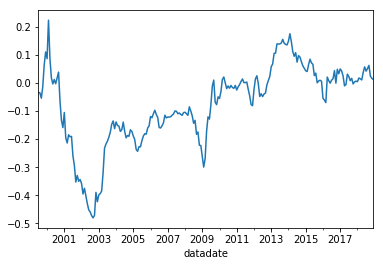

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.111131
2000-12-31   -0.242895
2001-12-31   -0.220477
2002-12-31   -0.120815
2003-12-31    0.452205
2004-12-31   -0.011326
2005-12-31    0.023303
2006-12-31    0.033856
2007-12-31    0.021581
2008-12-31   -0.131236
2009-12-31    0.223376
2010-12-31    0.042805
2011-12-31   -0.072894
2012-12-31    0.113920
2013-12-31    0.109511
2014-12-31   -0.073222
2015-12-31   -0.043981
2016-12-31    0.026268
2017-12-31   -0.025223
2018-12-31    0.005495
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     77.72
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.51e-41
Time:                        00:47:20   Log-Likelihood:                 548.57
No. Observations:                 234   AIC:                            -1087.
Df Residuals:                     229   BIC:                            -1070.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      1.128      0.261      -0.001       0.005
mktrf          0.1274      0.044      2.912      0.004       0.041       0.214
me             0.2219      0.051      4.360      0.000       0.122       0.322
ia            -0.1131      0.077     -1.463      0.145      -0.266       0.039
roe           -0.6254      0.066     -9.445      0.000      -0.756      -0.495
==============================================================================
Omnibus:                       20.170   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.428
Skew:                           0.367   Prob(JB):                     5.03e-11
Kurtosis:                       5.080   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     88.31
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.79e-45
Time:                        00:47:20   Log-Likelihood:                 548.57
No. Observations:                 234   AIC:                            -1087.
Df Residuals:                     229   BIC:                            -1070.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.875      0.381      -0.002       0.006
mktrf          0.1274      0.049      2.603      0.009       0.031       0.223
me             0.2219      0.050      4.472      0.000       0.125       0.319
ia            -0.1131      0.112     -1.014      0.311      -0.332       0.106
roe           -0.6254      0.114     -5.490      0.000      -0.849      -0.402
==============================================================================
Omnibus:                       20.170   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.428
Skew:                           0.367   Prob(JB):                     5.03e-11
Kurtosis:                       5.080   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     143.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.97e-61
Time:                        00:47:20   Log-Likelihood:                 548.57
No. Observations:                 234   AIC:                            -1087.
Df Residuals:                     229   BIC:                            -1070.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.885      0.376      -0.002       0.006
mktrf          0.1274      0.044      2.900      0.004       0.041       0.214
me             0.2219      0.043      5.167      0.000       0.138       0.306
ia            -0.1131      0.107     -1.053      0.292      -0.324       0.097
roe           -0.6254      0.110     -5.710      0.000      -0.840      -0.411
==============================================================================
Omnibus:                       20.170   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.428
Skew:                           0.367   Prob(JB):                     5.03e-11
Kurtosis:                       5.080   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     59.45
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.93e-39
Time:                        00:47:20   Log-Likelihood:                 545.87
No. Observations:                 234   AIC:                            -1080.
Df Residuals:                     228   BIC:                            -1059.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.163      0.246      -0.001       0.005
mktrf          0.1690      0.044      3.802      0.000       0.081       0.257
smb            0.1830      0.059      3.121      0.002       0.067       0.299
hml            0.0729      0.069      1.054      0.293      -0.063       0.209
rmw           -0.6603      0.078     -8.445      0.000      -0.814      -0.506
cma           -0.0261      0.099     -0.263      0.793      -0.222       0.170
==============================================================================
Omnibus:                       31.433   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.250
Skew:                           0.670   Prob(JB):                     1.12e-14
Kurtosis:                       5.189   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     35.57
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.76e-27
Time:                        00:47:20   Log-Likelihood:                 545.87
No. Observations:                 234   AIC:                            -1080.
Df Residuals:                     228   BIC:                            -1059.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.119      0.263      -0.001       0.005
mktrf          0.1690      0.050      3.406      0.001       0.072       0.266
smb            0.1830      0.051      3.597      0.000       0.083       0.283
hml            0.0729      0.100      0.726      0.468      -0.124       0.270
rmw           -0.6603      0.101     -6.514      0.000      -0.859      -0.462
cma           -0.0261      0.136     -0.192      0.848      -0.293       0.241
==============================================================================
Omnibus:                       31.433   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.250
Skew:                           0.670   Prob(JB):                     1.12e-14
Kurtosis:                       5.189   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     52.40
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.89e-36
Time:                        00:47:20   Log-Likelihood:                 545.87
No. Observations:                 234   AIC:                            -1080.
Df Residuals:                     228   BIC:                            -1059.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.157      0.247      -0.001       0.005
mktrf          0.1690      0.047      3.568      0.000       0.076       0.262
smb            0.1830      0.049      3.714      0.000       0.086       0.280
hml            0.0729      0.089      0.820      0.412      -0.101       0.247
rmw           -0.6603      0.099     -6.699      0.000      -0.853      -0.467
cma           -0.0261      0.135     -0.194      0.846      -0.290       0.238
==============================================================================
Omnibus:                       31.433   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.250
Skew:                           0.670   Prob(JB):                     1.12e-14
Kurtosis:                       5.189   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     57.56
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.47e-33
Time:                        00:47:20   Log-Likelihood:                 529.64
No. Observations:                 234   AIC:                            -1049.
Df Residuals:                     229   BIC:                            -1032.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.250      0.803      -0.004       0.003
mktrf          0.2462      0.044      5.636      0.000       0.160       0.332
smb            0.4661      0.055      8.549      0.000       0.359       0.574
hml           -0.1317      0.054     -2.432      0.016      -0.238      -0.025
umd           -0.2024      0.036     -5.694      0.000      -0.272      -0.132
==============================================================================
Omnibus:                       24.407   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.052
Skew:                           0.505   Prob(JB):                     4.98e-12
Kurtosis:                       5.079   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     27.07
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.10e-18
Time:                        00:47:20   Log-Likelihood:                 529.64
No. Observations:                 234   AIC:                            -1049.
Df Residuals:                     229   BIC:                            -1032.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.217      0.829      -0.004       0.003
mktrf          0.2462      0.050      4.878      0.000       0.147       0.345
smb            0.4661      0.069      6.741      0.000       0.331       0.602
hml           -0.1317      0.080     -1.651      0.099      -0.288       0.025
umd           -0.2024      0.058     -3.464      0.001      -0.317      -0.088
==============================================================================
Omnibus:                       24.407   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.052
Skew:                           0.505   Prob(JB):                     4.98e-12
Kurtosis:                       5.079   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     25.84
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.10e-17
Time:                        00:47:20   Log-Likelihood:                 529.64
No. Observations:                 234   AIC:                            -1049.
Df Residuals:                     229   BIC:                            -1032.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.216      0.829      -0.004       0.003
mktrf          0.2462      0.050      4.912      0.000       0.148       0.344
smb            0.4661      0.060      7.790      0.000       0.349       0.583
hml           -0.1317      0.084     -1.560      0.119      -0.297       0.034
umd           -0.2024      0.058     -3.484      0.000      -0.316      -0.089
==============================================================================
Omnibus:                       24.407   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.052
Skew:                           0.505   Prob(JB):                     4.98e-12
Kurtosis:                       5.079   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     42.08
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.07e-21
Time:                        00:47:20   Log-Likelihood:                 260.43
No. Observations:                 120   AIC:                            -510.9
Df Residuals:                     115   BIC:                            -496.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.691      0.491      -0.003       0.007
mktrf          0.1815      0.073      2.496      0.014       0.037       0.326
me             0.2315      0.072      3.223      0.002       0.089       0.374
ia            -0.1606      0.112     -1.428      0.156      -0.383       0.062
roe           -0.5397      0.100     -5.421      0.000      -0.737      -0.342
==============================================================================
Omnibus:                       11.883   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               18.890
Skew:                           0.455   Prob(JB):                     7.91e-05
Kurtosis:                       4.717   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     78.51
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.70e-32
Time:                        00:47:20   Log-Likelihood:                 260.43
No. Observations:                 120   AIC:                            -510.9
Df Residuals:                     115   BIC:                            -496.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.004      0.488      0.626      -0.006       0.009
mktrf          0.1815      0.080      2.280      0.023       0.025       0.338
me             0.2315      0.074      3.125      0.002       0.086       0.377
ia            -0.1606      0.156     -1.030      0.303      -0.466       0.145
roe           -0.5397      0.160     -3.383      0.001      -0.852      -0.227
==============================================================================
Omnibus:                       11.883   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               18.890
Skew:                           0.455   Prob(JB):                     7.91e-05
Kurtosis:                       4.717   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     132.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.75e-42
Time:                        00:47:20   Log-Likelihood:                 260.43
No. Observations:                 120   AIC:                            -510.9
Df Residuals:                     115   BIC:                            -496.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.004      0.494      0.622      -0.006       0.009
mktrf          0.1815      0.066      2.745      0.006       0.052       0.311
me             0.2315      0.067      3.466      0.001       0.101       0.362
ia            -0.1606      0.149     -1.081      0.280      -0.452       0.131
roe           -0.5397      0.150     -3.608      0.000      -0.833      -0.247
==============================================================================
Omnibus:                       11.883   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               18.890
Skew:                           0.455   Prob(JB):                     7.91e-05
Kurtosis:                       4.717   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     37.05
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.14e-22
Time:                        00:47:20   Log-Likelihood:                 264.22
No. Observations:                 120   AIC:                            -516.4
Df Residuals:                     114   BIC:                            -499.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.003      1.217      0.226      -0.002       0.009
mktrf          0.2251      0.075      3.017      0.003       0.077       0.373
smb            0.1672      0.085      1.978      0.050      -0.000       0.335
hml            0.0142      0.104      0.137      0.892      -0.191       0.219
rmw           -0.6030      0.122     -4.937      0.000      -0.845      -0.361
cma           -0.0193      0.134     -0.144      0.886      -0.284       0.246
==============================================================================
Omnibus:                       17.903   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.588
Skew:                           0.735   Prob(JB):                     1.68e-06
Kurtosis:                       4.777   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     33.93
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.27e-21
Time:                        00:47:20   Log-Likelihood:                 264.22
No. Observations:                 120   AIC:                            -516.4
Df Residuals:                     114   BIC:                            -499.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.003      1.049      0.294      -0.003       0.009
mktrf          0.2251      0.084      2.678      0.007       0.060       0.390
smb            0.1672      0.075      2.238      0.025       0.021       0.314
hml            0.0142      0.105      0.135      0.892      -0.191       0.219
rmw           -0.6030      0.140     -4.300      0.000      -0.878      -0.328
cma           -0.0193      0.149     -0.129      0.897      -0.312       0.274
==============================================================================
Omnibus:                       17.903   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.588
Skew:                           0.735   Prob(JB):                     1.68e-06
Kurtosis:                       4.777   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     48.89
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.37e-27
Time:                        00:47:20   Log-Likelihood:                 264.22
No. Observations:                 120   AIC:                            -516.4
Df Residuals:                     114   BIC:                            -499.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.003      1.109      0.267      -0.003       0.009
mktrf          0.2251      0.073      3.077      0.002       0.082       0.369
smb            0.1672      0.068      2.465      0.014       0.034       0.300
hml            0.0142      0.078      0.182      0.855      -0.138       0.166
rmw           -0.6030      0.136     -4.444      0.000      -0.869      -0.337
cma           -0.0193      0.143     -0.135      0.893      -0.299       0.261
==============================================================================
Omnibus:                       17.903   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.588
Skew:                           0.735   Prob(JB):                     1.68e-06
Kurtosis:                       4.777   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     40.68
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.34e-21
Time:                        00:47:20   Log-Likelihood:                 259.22
No. Observations:                 120   AIC:                            -508.4
Df Residuals:                     115   BIC:                            -494.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.003      0.128      0.898      -0.005       0.006
mktrf          0.3186      0.065      4.923      0.000       0.190       0.447
smb            0.4459      0.074      6.052      0.000       0.300       0.592
hml           -0.2002      0.074     -2.712      0.008      -0.346      -0.054
umd           -0.1779      0.046     -3.909      0.000      -0.268      -0.088
==============================================================================
Omnibus:                       13.132   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.818
Skew:                           0.582   Prob(JB):                     0.000135
Kurtosis:                       4.486   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     27.45
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.32e-16
Time:                        00:47:20   Log-Likelihood:                 259.22
No. Observations:                 120   AIC:                            -508.4
Df Residuals:                     115   BIC:                            -494.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.003      0.103      0.918      -0.006       0.007
mktrf          0.3186      0.066      4.863      0.000       0.190       0.447
smb            0.4459      0.081      5.500      0.000       0.287       0.605
hml           -0.2002      0.081     -2.476      0.013      -0.359      -0.042
umd           -0.1779      0.063     -2.838      0.005      -0.301      -0.055
==============================================================================
Omnibus:                       13.132   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.818
Skew:                           0.582   Prob(JB):                     0.000135
Kurtosis:                       4.486   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     30.21
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.54e-17
Time:                        00:47:20   Log-Likelihood:                 259.22
No. Observations:                 120   AIC:                            -508.4
Df Residuals:                     115   BIC:                            -494.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.003      0.106      0.916      -0.006       0.007
mktrf          0.3186      0.054      5.955      0.000       0.214       0.423
smb            0.4459      0.069      6.459      0.000       0.311       0.581
hml           -0.2002      0.068     -2.948      0.003      -0.333      -0.067
umd           -0.1779      0.061     -2.937      0.003      -0.297      -0.059
==============================================================================
Omnibus:                       13.132   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.818
Skew:                           0.582   Prob(JB):                     0.000135
Kurtosis:                       4.486   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     32.41
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.67e-18
Time:                        00:47:20   Log-Likelihood:                 303.36
No. Observations:                 114   AIC:                            -596.7
Df Residuals:                     109   BIC:                            -583.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.338      0.184      -0.001       0.006
mktrf          0.0666      0.051      1.309      0.193      -0.034       0.167
me             0.2260      0.078      2.879      0.005       0.070       0.382
ia            -0.0200      0.109     -0.184      0.855      -0.236       0.196
roe           -0.7601      0.096     -7.945      0.000      -0.950      -0.570
==============================================================================
Omnibus:                        5.358   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                4.886
Skew:                           0.494   Prob(JB):                       0.0869
Kurtosis:                       3.227   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     39.05
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.98e-20
Time:                        00:47:20   Log-Likelihood:                 303.36
No. Observations:                 114   AIC:                            -596.7
Df Residuals:                     109   BIC:                            -583.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.807      0.071      -0.000       0.005
mktrf          0.0666      0.047      1.408      0.159      -0.026       0.159
me             0.2260      0.038      5.900      0.000       0.151       0.301
ia            -0.0200      0.115     -0.174      0.862      -0.245       0.205
roe           -0.7601      0.099     -7.716      0.000      -0.953      -0.567
==============================================================================
Omnibus:                        5.358   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                4.886
Skew:                           0.494   Prob(JB):                       0.0869
Kurtosis:                       3.227   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     51.47
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.85e-24
Time:                        00:47:20   Log-Likelihood:                 303.36
No. Observations:                 114   AIC:                            -596.7
Df Residuals:                     109   BIC:                            -583.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.133      0.033       0.000       0.004
mktrf          0.0666      0.045      1.478      0.139      -0.022       0.155
me             0.2260      0.032      7.035      0.000       0.163       0.289
ia            -0.0200      0.120     -0.166      0.868      -0.256       0.216
roe           -0.7601      0.095     -8.020      0.000      -0.946      -0.574
==============================================================================
Omnibus:                        5.358   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                4.886
Skew:                           0.494   Prob(JB):                       0.0869
Kurtosis:                       3.227   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     16.41
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.08e-12
Time:                        00:47:20   Log-Likelihood:                 290.90
No. Observations:                 114   AIC:                            -569.8
Df Residuals:                     108   BIC:                            -553.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.585      0.560      -0.003       0.005
mktrf          0.1053      0.054      1.939      0.055      -0.002       0.213
smb            0.2540      0.088      2.880      0.005       0.079       0.429
hml            0.1300      0.112      1.156      0.250      -0.093       0.353
rmw           -0.6065      0.138     -4.403      0.000      -0.880      -0.334
cma            0.0636      0.175      0.364      0.717      -0.283       0.410
==============================================================================
Omnibus:                        6.311   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                6.724
Skew:                           0.366   Prob(JB):                       0.0347
Kurtosis:                       3.938   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     12.20
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.21e-09
Time:                        00:47:20   Log-Likelihood:                 290.90
No. Observations:                 114   AIC:                            -569.8
Df Residuals:                     108   BIC:                            -553.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.809      0.418      -0.002       0.004
mktrf          0.1053      0.051      2.078      0.038       0.006       0.205
smb            0.2540      0.063      4.016      0.000       0.130       0.378
hml            0.1300      0.133      0.977      0.328      -0.131       0.391
rmw           -0.6065      0.178     -3.407      0.001      -0.955      -0.258
cma            0.0636      0.199      0.319      0.750      -0.327       0.454
==============================================================================
Omnibus:                        6.311   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                6.724
Skew:                           0.366   Prob(JB):                       0.0347
Kurtosis:                       3.938   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     18.30
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.01e-13
Time:                        00:47:20   Log-Likelihood:                 290.90
No. Observations:                 114   AIC:                            -569.8
Df Residuals:                     108   BIC:                            -553.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.927      0.354      -0.001       0.004
mktrf          0.1053      0.048      2.184      0.029       0.011       0.200
smb            0.2540      0.051      4.944      0.000       0.153       0.355
hml            0.1300      0.145      0.894      0.371      -0.155       0.415
rmw           -0.6065      0.169     -3.587      0.000      -0.938      -0.275
cma            0.0636      0.221      0.287      0.774      -0.370       0.497
==============================================================================
Omnibus:                        6.311   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                6.724
Skew:                           0.366   Prob(JB):                       0.0347
Kurtosis:                       3.938   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     15.30
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.81e-10
Time:                        00:47:20   Log-Likelihood:                 284.10
No. Observations:                 114   AIC:                            -558.2
Df Residuals:                     109   BIC:                            -544.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.307      0.759      -0.003       0.005
mktrf          0.1277      0.057      2.239      0.027       0.015       0.241
smb            0.3888      0.089      4.371      0.000       0.212       0.565
hml            0.1668      0.092      1.821      0.071      -0.015       0.348
umd           -0.1707      0.069     -2.471      0.015      -0.308      -0.034
==============================================================================
Omnibus:                        8.361   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               14.719
Skew:                           0.224   Prob(JB):                     0.000637
Kurtosis:                       4.702   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     13.28
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.52e-09
Time:                        00:47:20   Log-Likelihood:                 284.10
No. Observations:                 114   AIC:                            -558.2
Df Residuals:                     109   BIC:                            -544.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.426      0.670      -0.002       0.004
mktrf          0.1277      0.054      2.381      0.017       0.023       0.233
smb            0.3888      0.075      5.181      0.000       0.242       0.536
hml            0.1668      0.140      1.196      0.232      -0.107       0.440
umd           -0.1707      0.072     -2.363      0.018      -0.312      -0.029
==============================================================================
Omnibus:                        8.361   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               14.719
Skew:                           0.224   Prob(JB):                     0.000637
Kurtosis:                       4.702   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     19.25
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.31e-12
Time:                        00:47:20   Log-Likelihood:                 284.10
No. Observations:                 114   AIC:                            -558.2
Df Residuals:                     109   BIC:                            -544.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.477      0.633      -0.002       0.003
mktrf          0.1277      0.049      2.614      0.009       0.032       0.224
smb            0.3888      0.064      6.118      0.000       0.264       0.513
hml            0.1668      0.147      1.135      0.257      -0.121       0.455
umd           -0.1707      0.066     -2.581      0.010      -0.300      -0.041
==============================================================================
Omnibus:                        8.361   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               14.719
Skew:                           0.224   Prob(JB):                     0.000637
Kurtosis:                       4.702   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""